fork https://www.kaggle.com/nishantrajadhyaksha/pawpularity-pytorchlightning-w-b

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 539.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
import os
import warnings
from pprint import pprint
from glob import glob
from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from box import Box
from timm import create_model
from sklearn.model_selection import StratifiedKFold, train_test_split
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
# from pytorch_grad_cam import GradCAMPlusPlus
# from pytorch_grad_cam.utils.image import show_cam_on_image


import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import LightningDataModule, LightningModule
# from pytorch_lightning.loggers import WandbLogger
import albumentations as A
from albumentations.pytorch import ToTensorV2
# import wandb
import cv2
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import shutil
import os
import pickle
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import TensorDataset
import time
warnings.filterwarnings("ignore")

In [3]:
# drive_root = '/content/drive/MyDrive/kaggle/pet_finder/'
drive_root = '..'

In [4]:
TRAIN_DIR = f"{drive_root}/input/petfinder-pawpularity-score/train"
TEST_DIR = f"{drive_root}/input/petfinder-pawpularity-score/test"
DENSE_FEATURES = [
    'Subject Focus',
    'Eyes',
    'Face',
    'Near',
    'Action',
    'Accessory',
    'Group',
    'Collage',
    'Human',
    'Occlusion',
    'Info',
    'Blur',
]

In [7]:
# wandb_logger = WandbLogger(project="petfinder")

In [5]:
# import pandas as pd
df_train = pd.read_csv(f"{drive_root}/input/petfinder-pawpularity-score/train.csv")
df_test = pd.read_csv(f"{drive_root}/input/petfinder-pawpularity-score/test.csv")
feature_name = df_train.columns[1:-1]
print(feature_name)
df_train.head()

Index(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group',
       'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],
      dtype='object')


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [6]:
df_train['filepath'] = df_train.Id.apply(lambda x :f"{TRAIN_DIR}/{x}.jpg" )
df_test['filepath'] = df_test.Id.apply(lambda x :f"{TEST_DIR}/{x}.jpg" )

In [7]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    
class QuantileLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, yhat, y, tau):
        diff = y.unsqueeze(dim=-1) - yhat
        loss = (diff * (tau - (~diff.detach().ge(0)).float())).mean()
        return loss
    
    
class CutRelu(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self,x):
        x = torch.relu(x) - torch.relu(x-1.)
        return x

In [8]:
import timm
#timm.list_models()

In [15]:
config = {'seed': 2021,
          'root': f"{drive_root}", 
          'n_splits': 10,#10,
          'epoch': 30,
          'gpu': 1,
          'trainer': {
              'gpus': 1,
              'auto_lr_find':False,
              'accumulate_grad_batches': 1,
              'progress_bar_refresh_rate': 1,
              'fast_dev_run': False,
              'num_sanity_val_steps': 0,
              'resume_from_checkpoint': None
#               'accelerator':'ddp',
#               'strategy':'ddp'
          },
          'transform':{
              'name': 'albu',
              'image_size': 224,#224,#384,
              'squared':True,
              'aug':'rotate,shift,scale,perspective,more',
          },
          'train_loader':{
              'batch_size': 100,
              'shuffle': True,
              'num_workers': 4,
              'pin_memory': False,
              'drop_last': True,
            
          },
          'val_loader': {
              'batch_size': 100,
              'shuffle': False,
              'num_workers': 4,
              'pin_memory': False,
              'drop_last': False
         },
          'save_discript':'Sigmoid_non_dropout',
          'model':{
              'name': 'swin_tiny_patch4_window7_224',#'swin_tiny_patch4_window7_224',#'swin_large_patch4_window12_384_in22k', 'deit_base_distilled_patch16_384'
              'img_feature_dim':128,
              'output_dim': 1,
              'last_drop':0.5,
              'quantile_num':100
              
          },
          'optimizer':{
              'name': 'optim.AdamW',
              'params':{
                  'lr': 1e-5
              },
          },
          'scheduler':{
              'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
              'params':{
                  'T_0': 4,
                  'T_mult':2,
                  'eta_min': 1e-7,
              }
          },
          'loss': 'QuantileLoss',#'nn.BCEWithLogitsLoss',
          'metric': 'RMSELoss',

          'svr':{
              'C':0.5
          },
          'svr_train':True,
          'swin_train':True
        
}

config = Box(config)

In [16]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(config.gpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # RGB
IMAGENET_STD = [0.229, 0.224, 0.225]  # RGB

train_transforms = A.Compose([
        A.LongestMaxSize(max_size= config.transform.image_size),
        A.PadIfNeeded(min_height=config.transform.image_size, min_width=config.transform.image_size, border_mode=cv2.BORDER_CONSTANT),
        A.OneOf([
                 # shift, scale, rotate 를 무작위로 적용합니다.
                 A.ShiftScaleRotate(shift_limit=(-0.2,0.2),scale_limit=(-0.2,0.1), rotate_limit=(-90,90)
                            , p=1.0, border_mode=cv2.BORDER_CONSTANT),
                 A.ShiftScaleRotate(shift_limit=(-0.2,0.2)
                            , p=1.0, border_mode=cv2.BORDER_CONSTANT),
                 A.ShiftScaleRotate(rotate_limit=(-90,90)
                            , p=1.0, border_mode=cv2.BORDER_CONSTANT),
                 A.ShiftScaleRotate(scale_limit=(-0.2,0.1)
                            , p=1.0, border_mode=cv2.BORDER_CONSTANT),
                 # affine 변환
                #  A.IAAAffine(shear=15, p=0.5, mode='constant')
        ], p=0.8),
        A.IAAPerspective(scale=(0.01, 0.15),p=0.3),
        A.OneOf([
            A.RandomContrast(limit=(-0.2,0.2), p=0.2),
            A.RandomGamma(gamma_limit=(80,120), eps=1e-07,p=0.2 )
        ],p=1.0),
        A.Cutout(max_h_size=8, max_w_size=8, num_holes=10, p=0.1),
        A.Downscale(scale_min = 0.8, scale_max=0.95, p=0.1),
        A.ISONoise(intensity=(0.1,0.5), color_shift=(0.01,0.05),p=0.1),
        A.OneOf([
            A.MotionBlur(blur_limit=(3,7),p=0.1),
             A.Blur(blur_limit=(3,7),p=0.1)],  p=1.0),
        
        A.HorizontalFlip(p=0.5),
        # blur
        # A.Blur(p=0.1),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2()
        ],
        )

valid_transforms = A.Compose([
        A.LongestMaxSize(max_size= config.transform.image_size),
        A.PadIfNeeded(min_height=config.transform.image_size, min_width=config.transform.image_size, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2()
        ],
        )

def imbal_sampler(lables):
    lables = (lables/10).astype(int)
    class_count = np.bincount(lables.squeeze())
    class_weighting = 1./class_count
    sample_weights = class_weighting[lables]
    sampler = WeightedRandomSampler(sample_weights, len(lables))
    return sampler


class PetfinderDataset(Dataset):
    def __init__(self, df, cfg, transform):#, image_size=224):
        self._X = df["filepath"].values
        self._feature = df[DENSE_FEATURES].values
        self._y = None
        self._cfg = cfg
        if "Pawpularity" in df.keys():
            self._y = df["Pawpularity"].values
        self.transform = transform    

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        image_path = self._X[idx]
        feature = self._feature[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = self.transform(image=image)["image"] #self._transform(image)
        if self._y is not None:
            label = self._y[idx]
            return {'image':image,'feature':feature}, label

        return {'image':image,'feature':feature}

In [18]:
class PetfinderDataModule(LightningDataModule):
    def __init__(
        self,
        train_df,
        val_df,
        cfg,
    ):
        super().__init__()
        self._train_df = train_df
        self._val_df = val_df
        self._cfg = cfg
#         self.sampler = imbal_sampler( self._train_df.Pawpularity)

    def __create_dataset(self, train=True):
        if train==True:
            return PetfinderDataset(self._train_df, self._cfg.transform, train_transforms)
        else:
            return PetfinderDataset(self._val_df, self._cfg.transform, valid_transforms)

    def train_dataloader(self):
        dataset = self.__create_dataset(True)
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = self.__create_dataset(False)
        return DataLoader(dataset, **self._cfg.val_loader)

In [19]:
torch.autograd.set_detect_anomaly(True)
seed_everything(config.seed)

Global seed set to 2021


2021

In [22]:
class Model(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self._criterion = eval(self.cfg.loss)()
        self._metric = eval(self.cfg.metric)()
        # self.transform = get_default_transforms()
        self.save_hyperparameters(cfg)
        self.tau = torch.Tensor((2 * np.arange(self.cfg.model.quantile_num) + 1) / (2.0 * self.cfg.model.quantile_num)).view(1, -1).to(device)
    def __build_model(self):
        self.backbone = create_model(
            self.cfg.model.name, pretrained=True, num_classes=0, in_chans=3
        )
       
        num_features = self.backbone.num_features
        self.img_feature_head = nn.Sequential(
            #nn.Dropout(self.cfg.model.last_drop), 
            nn.Linear(num_features, self.cfg.model.img_feature_dim),
            nn.SELU()
        )
        self.dense1 = nn.Sequential(
            #nn.Dropout(0.1), 
            nn.Linear(12+self.cfg.model.img_feature_dim, 64),
            nn.SELU()
        )
        self.dense2 = nn.Linear(64, self.cfg.model.quantile_num)
        self.last_activate = nn.Sigmoid()

    def forward(self, image, features, targets=None):
        x1 = self.backbone(image)
        x = self.img_feature_head(x1)
        x = torch.cat([x, features], dim=1)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

    def predict(self, images, features):
        embed = self.backbone(images)
        embed2 = self.img_feature_head(embed)
        embed3 = torch.cat([embed2, features], dim=1)
        embed4 = self.dense1(embed3)
        out = self.dense2(embed4)
        
        qunatile = self.last_activate(out)
        pred = qunatile.detach().median(dim=-1)[0].cpu() * 100.
        pred_median = pred.median(dim=-1)[0].detach().cpu().numpy().squeeze() * 100
        pred_mean = pred.mean(dim=-1).detach().cpu().numpy().squeeze() * 100
        qunatile = qunatile.detach().cpu().numpy()
        embed = embed.detach().cpu().numpy().squeeze()
        embed2 = embed2.detach().cpu().numpy().squeeze()
        embed3 = embed3.detach().cpu().numpy().squeeze()
        embed4 = embed4.detach().cpu().numpy().squeeze()
        return qunatile, embed, embed2,embed3, embed4

    def training_step(self, batch, batch_idx):
        loss, pred, labels, metric = self.__share_step(batch, 'train')
        self.log("train_loss",loss,on_step=False,on_epoch=True)
        self.log("train_metric",metric, on_step=False,on_epoch=True , prog_bar=True)
        return {'loss': loss, 'pred': pred, 'labels': labels, 'metric':metric}
        
    def validation_step(self, batch, batch_idx):
        loss, pred, labels, metric = self.__share_step(batch, 'val')
        self.log("val_loss",loss,on_step=False,on_epoch=True)
        self.log("val_metric",metric, on_step=False, on_epoch=True, prog_bar=True)
        return {'pred': pred, 'labels': labels,'val_loss':loss, 'val_metric':metric}
    
    def __share_step(self, batch, mode):
        X, labels = batch
        labels = labels.float() / 100.0        
        logits = self.forward(X['image'],X['feature']).squeeze(1)
        pred = self.last_activate(logits)
        loss = self._criterion(pred, labels, self.tau)
        
        
        pred = pred.detach().cpu() * 100.
        labels = labels.detach().cpu() * 100.
        metric = self._metric(pred.median(dim=-1)[0],labels)
        return loss, pred, labels, metric
    
    
    def configure_optimizers(self):
        optimizer = eval(self.cfg.optimizer.name)(
        self.parameters(), **self.cfg.optimizer.params
        )
        scheduler = eval(self.cfg.scheduler.name)(
        optimizer,
        **self.cfg.scheduler.params
        )
        return [optimizer], [scheduler]

In [22]:
# df_train
# datamodule.train_dataloader().__len__() +datamodule.val_dataloader().__len__()

In [23]:
# pl.Trainer()

In [24]:
# callbacks.ModelCheckpoint?

In [56]:
skf = StratifiedKFold(
    n_splits=config.n_splits, shuffle=True, random_state=config.seed
)

swin_scores=[]
svr_scores=[]
ens_scores= []
all_fold_quantile_pred= []

for fold, (train_idx, val_idx) in enumerate(skf.split(df_train["Id"], df_train["Pawpularity"])):
    model_save_dir = f'{drive_root}/output/weights/{config.model.name}_{config.save_discript}/'
    train_df = df_train.loc[train_idx].reset_index(drop=True)
    val_df = df_train.loc[val_idx].reset_index(drop=True)
    swin_score=0
    model = Model.load_from_checkpoint(f'{model_save_dir}swin_fold{fold}.ckpt', cfg = config)
    model = model.to("cuda")
    model.eval()
    model.freeze()

    val_predicts = []
    quantile_pred= []
    val_embed_features = []
    val_dataloader = DataLoader(PetfinderDataset(val_df, config.transform, valid_transforms), **config.val_loader)
    for data in val_dataloader:
        quantile, embed, embed2,embed3, embed4 = model.predict(data[0]['image'].to("cuda"),data[0]['feature'].to("cuda"))
        quantile_pred.append(quantile)
        #val_predicts.append(y_preds)
        #val_embed_features.append(embed)

    #val_predicts = np.concatenate(val_predicts)
    quantile_pred = np.concatenate(quantile_pred)
    all_fold_quantile_pred.append(quantile_pred)
#    embed_val_X = np.concatenate(val_embed_features)
       
    #swin_score =  mean_squared_error(val_df.Pawpularity, val_predicts)**0.5
    #swin_scores.append(swin_score)
    #print(f'fold{fold} score swin : {swin_score:.2f}')


KeyboardInterrupt: 

In [59]:
all_fold_quantile_pred[0].shape

(992, 100)

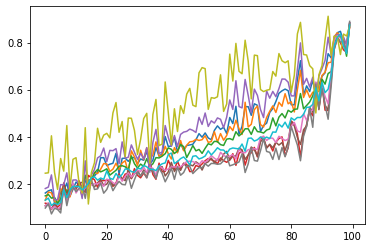

In [66]:
for i in range(10,20):
    pred = all_fold_quantile_pred[0][i]
    plt.plot(pred)

In [51]:
cv_score_list = []
for i in range(100):
    score_list = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(df_train["Id"], df_train["Pawpularity"])):
        train_df = df_train.loc[train_idx].reset_index(drop=True)
        val_df = df_train.loc[val_idx].reset_index(drop=True)

        pred = all_fold_quantile_pred[fold]
        val_predicts = pred[:, i] * 100
        swin_score =  mean_squared_error(val_df.Pawpularity, val_predicts)**0.5
        score_list.append(swin_score)
    cv_score = sum(score_list)/10.
    cv_score_list.append(cv_score)
#     print(f'quantile{i} score swin : {cv_score:.2f}')


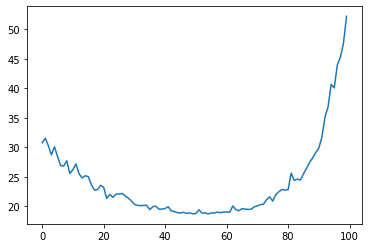

In [54]:
plt.plot(cv_score_list)

In [55]:
min(cv_score_list)

18.687395979196708

In [26]:
if trainer.global_rank==0:
#     score_path =  f'{drive_root}/output/score_history.csv'
    cur_score_df = pd.json_normalize(config)
    cur_score_df['swin_mean_score'] = np.mean(swin_scores)
    cur_score_df['svr_mean_score'] = np.mean(svr_scores)
    cur_score_df['ens_mean_score'] = np.mean(ens_scores)
    cur_score_df['model_path'] = model_save_dir

    score_path =  f'{drive_root}/output/score_history.csv'
    if os.path.isfile(score_path):
        score_df = pd.read_csv(score_path)
        cur_score_df = pd.concat([score_df,cur_score_df])

#     cur_score_df.to_csv(score_path, index=False)
    print(f'avg ensemble score : {np.mean(ens_scores)}')

NameError: name 'trainer' is not defined

In [39]:
answer = []
for fold, (train_idx, val_idx) in enumerate(skf.split(df_train["Id"], df_train["Pawpularity"])):
    val_df = df_train.loc[val_idx].reset_index(drop=True)
    answer.extend(val_df.Pawpularity.tolist())
answer = np.array(answer)

In [30]:
condi = np.concatenate(quantile_pred, axis=0) * 100

In [43]:
scores = []
for i in range(100):
    pred = condi[:, i]
    rmse = mean_squared_error(answer, pred)**0.5
    scores.append(rmse)

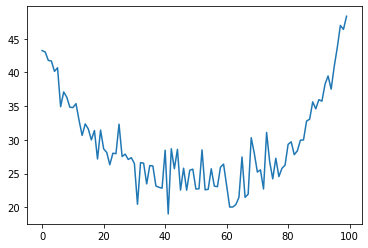

In [44]:
plt.plot(scores)

In [53]:
print(scores[61])
np.array(scores).argsort()

20.027575455937694


array([41, 61, 62, 63, 31, 64, 66, 67, 47, 45, 53, 54, 72, 50, 51, 39, 38,
       57, 56, 37, 60, 34, 75, 77, 70, 48, 71, 49, 55, 43, 78, 46, 58, 36,
       35, 79, 22, 59, 30, 33, 32, 74, 28, 18, 76, 29, 65, 26, 82, 27, 24,
       69, 23, 21, 83, 40, 52, 44, 20, 42, 80, 81, 84, 85, 16, 68, 13, 73,
       17, 19, 15, 25, 14, 86, 12, 87, 89, 10,  9,  6, 11, 88, 91, 90,  8,
        7, 94, 92, 93,  4,  5, 95,  3,  2,  1,  0, 96, 98, 97, 99])

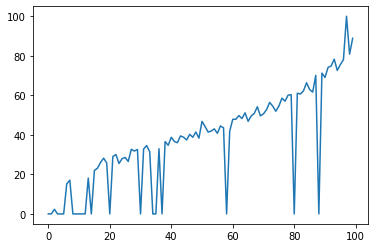

In [103]:
plt.plot(condi[9])

In [91]:
tau = torch.Tensor((2 * np.arange(config.model.quantile_num) + 1) / (2.0 * config.model.quantile_num)).view(1, -1)

In [92]:
tau[0]

tensor([0.0050, 0.0150, 0.0250, 0.0350, 0.0450, 0.0550, 0.0650, 0.0750, 0.0850,
        0.0950, 0.1050, 0.1150, 0.1250, 0.1350, 0.1450, 0.1550, 0.1650, 0.1750,
        0.1850, 0.1950, 0.2050, 0.2150, 0.2250, 0.2350, 0.2450, 0.2550, 0.2650,
        0.2750, 0.2850, 0.2950, 0.3050, 0.3150, 0.3250, 0.3350, 0.3450, 0.3550,
        0.3650, 0.3750, 0.3850, 0.3950, 0.4050, 0.4150, 0.4250, 0.4350, 0.4450,
        0.4550, 0.4650, 0.4750, 0.4850, 0.4950, 0.5050, 0.5150, 0.5250, 0.5350,
        0.5450, 0.5550, 0.5650, 0.5750, 0.5850, 0.5950, 0.6050, 0.6150, 0.6250,
        0.6350, 0.6450, 0.6550, 0.6650, 0.6750, 0.6850, 0.6950, 0.7050, 0.7150,
        0.7250, 0.7350, 0.7450, 0.7550, 0.7650, 0.7750, 0.7850, 0.7950, 0.8050,
        0.8150, 0.8250, 0.8350, 0.8450, 0.8550, 0.8650, 0.8750, 0.8850, 0.8950,
        0.9050, 0.9150, 0.9250, 0.9350, 0.9450, 0.9550, 0.9650, 0.9750, 0.9850,
        0.9950])

In [78]:
answer = torch.Tensor(answer)

In [79]:
condi_tensor = torch.Tensor(condi)

In [75]:
condi_tensor.shape

torch.Size([9912, 100])

In [84]:
answer.shape

torch.Size([9912])

In [85]:
answer[0]

tensor(34.)

In [86]:
condi_tensor[0]

tensor([ 0.0000,  0.0000,  6.4869,  0.0000,  0.0000,  0.0000,  8.9659,  4.7182,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 17.1887,  0.0000, 10.1548,
        18.1141, 16.0629, 16.1244, 15.2122,  0.0000, 13.6979, 17.4475, 13.8063,
        18.5768, 22.4048, 25.2927, 22.8560, 20.4375, 22.1053,  0.0000, 29.1486,
        26.0620, 25.5340,  0.0000,  0.0000, 24.2385,  0.0000, 24.8445, 28.5092,
        22.9260, 27.4135, 22.6711, 20.6050, 31.6714, 22.5670, 22.8328, 29.2871,
        30.1256, 24.7123, 24.7102, 15.1827, 25.8786, 25.2469, 32.8231, 34.7283,
        26.6006, 34.0312,  0.0000, 33.5300, 28.3349, 23.3503, 32.0872, 28.6380,
        27.5093, 33.1836, 20.5460, 35.4523, 37.3503, 45.6510, 41.1763, 24.1516,
        33.5462, 39.1950, 40.5770, 30.1996, 35.7885, 43.0843, 42.7187, 34.0430,
         0.0000, 36.7898, 44.3648, 42.1418, 44.4066, 39.8122, 42.4619, 42.1610,
         0.0000, 47.5326, 44.2503, 55.7792, 40.7980, 45.9135, 41.7953, 50.7415,
        54.0751, 77.3520, 55.2619, 60.62

In [87]:
diff = answer.unsqueeze(dim=-1) - condi_tensor

In [90]:
diff[0].int()

tensor([ 34,  34,  27,  34,  34,  34,  25,  29,  34,  34,  34,  34,  34,  16,
         34,  23,  15,  17,  17,  18,  34,  20,  16,  20,  15,  11,   8,  11,
         13,  11,  34,   4,   7,   8,  34,  34,   9,  34,   9,   5,  11,   6,
         11,  13,   2,  11,  11,   4,   3,   9,   9,  18,   8,   8,   1,   0,
          7,   0,  34,   0,   5,  10,   1,   5,   6,   0,  13,  -1,  -3, -11,
         -7,   9,   0,  -5,  -6,   3,  -1,  -9,  -8,   0,  34,  -2, -10,  -8,
        -10,  -5,  -8,  -8,  34, -13, -10, -21,  -6, -11,  -7, -16, -20, -43,
        -21, -26], dtype=torch.int32)

In [88]:
diff * (tau - (~diff.ge(0)).float())

tensor([[0.1700, 0.5100, 0.6878,  ..., 1.0838, 0.3189, 0.1331],
        [0.1350, 0.4050, 0.5845,  ..., 1.7196, 0.6506, 0.2699],
        [0.3350, 1.0050, 1.4805,  ..., 0.8250, 0.4950, 0.1650],
        ...,
        [0.5000, 1.5000, 2.5000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1750, 0.5250, 0.8750,  ..., 0.2731, 0.2361, 0.1155],
        [0.1500, 0.4500, 0.7500,  ..., 0.6285, 0.4297, 0.1799]])

In [ ]:
diff = y.unsqueeze(dim=-1) - yhat
loss = (diff * (tau - (~diff.detach().ge(0)).float())).mean()
return loss

In [98]:
l = nn.Linear(64, 100)

In [99]:
l.bias

Parameter containing:
tensor([ 0.0466, -0.1216, -0.0230,  0.1000,  0.1162,  0.1011,  0.0300,  0.0694,
        -0.0500, -0.0487, -0.0581, -0.1039, -0.0715,  0.0433,  0.0208, -0.0306,
        -0.1027,  0.0887,  0.0728, -0.0241,  0.0041,  0.1188,  0.1168, -0.1223,
        -0.0239,  0.1133, -0.0817,  0.0554, -0.0363,  0.1192, -0.0146,  0.0559,
         0.0286, -0.0822, -0.0078,  0.0761,  0.1235, -0.0367,  0.1011,  0.0093,
         0.0113, -0.0642,  0.0129, -0.0928,  0.0640, -0.0937,  0.0016,  0.0303,
        -0.1098,  0.0302,  0.0531, -0.0346, -0.0175, -0.0313,  0.0904,  0.0248,
        -0.0876,  0.0874,  0.0153, -0.0321, -0.0179,  0.0410,  0.0316,  0.0923,
         0.0197, -0.1071,  0.0334, -0.0710, -0.0241, -0.1083, -0.0829, -0.1135,
        -0.0564, -0.0585,  0.0938,  0.0877, -0.0050,  0.0577,  0.0345,  0.0363,
         0.1145,  0.1048,  0.0441,  0.0160, -0.0479, -0.0732,  0.0299,  0.0878,
        -0.0906,  0.1126,  0.0340,  0.0489, -0.0544,  0.0539, -0.0226, -0.0639,
         0.0068,  

In [100]:
nn.init.constant_(l.bias, 1)

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)